In [1]:
from keras.models import Sequential,Model,load_model
from keras.layers import Input,Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta, Adam, Adagrad, RMSprop
from keras import regularizers
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def imagegen(train_path, valid_path, test_path, batch_size):
    
    '''
    Image generator function 
    
    Parameters:
    train_path - path to the training data set
    valid_path - path to the validation data set
    test_path - path to the test data set
    batch_size - batch size 
    
    
    return: (train_generator, validation_generator, testing_generator)  
    - training image generator, validation image generator, testing image generator
    '''
    # training images augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        validation_split=0.2)
    
    # validation augmentation
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    # test augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # generator that read into subfolders of 'data/train'
    train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=image_size,  # all images will be resized to 160x120
        batch_size=batch_size,
        class_mode='categorical',subset='training') 

    # this is a similar generator, for validation data
    validation_generator = train_datagen.flow_from_directory(
            train_path,  # this is the target directory
            target_size=image_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',subset='validation')
    
    testing_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=image_size,
            batch_size=batch_size,
            shuffle = False,
            class_mode='categorical')
    return train_generator, validation_generator, testing_generator

In [3]:
# training model

def fit(model, model_name, image_generator, batch_size, epochs, no_train_img, no_valid_img):
    
    '''
    training function to rain CNN model 
    
    Parameters:
    
    model - CNN model
    model_name - model name to save data 
    image_generator - generator to generate train/validation images
    batch_size - batch size
    epochs - number of epochs 
    no_train_img - number of training images
    no_valid_img - number of validation images
    '''
    
    #tensorboard
    print(model.summary())
    tbc = TensorBoard(log_dir='/output/{}'.format(model_name), 
                      histogram_freq=0, write_graph=True, write_images=True)
    
    history =model.fit_generator(
        image_generator[0],
        steps_per_epoch=no_train_img // batch_size,
        epochs=epochs,
        validation_data=image_generator[1],
        validation_steps=no_valid_img // batch_size,callbacks=[tbc]  )
    
    #save
    model.save('{}.h5'.format(model_name)) 
    model.save_weights('{}_weights.h5'.format(model_name)) 
    
    #plot
    
    # Loss Curves
    plt.figure(figsize=[8,6]);
    plt.plot(history.history['loss'],'r',linewidth=3.0);
    plt.plot(history.history['val_loss'],'b',linewidth=3.0);
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Loss',fontsize=16);
    plt.title('Loss Curves {}'.format(model_name),fontsize=16);
   

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0);
    plt.plot(history.history['val_acc'],'b',linewidth=3.0);
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Accuracy',fontsize=16);
    plt.title('Accuracy Curves {}'.format(model_name),fontsize=16);
   

    print(history.history['val_acc'][-1])

In [4]:
# testing model 
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report


#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='cividis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#test function
    
def predict(model,model_name,image_generator,no_images,batch_size):
    
    '''
    Test function to test the CNN model 
    
    
    model - CNN model
    model_name - model name to save data 
    image_generator - image generator to generate test images
    batch_size = batch size 
    
    
    
    '''
    dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
    steps=no_images/batch_size
    predictions = model.predict_generator(image_generator[2],steps=steps)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = image_generator[2].classes
    class_labels = list(image_generator[2].class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)  
    cm =confusion_matrix(true_classes, predicted_classes)
    cm_plot_labels = list(image_generator[2].class_indices.keys()) 
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix {}'.format(model_name))

In [5]:
#parameters
batch_size = 32
image_size = (60, 80)
input_shape = (60, 80, 3)
epochs = 50

#specify paths for train and test sets
train_path = 'C:/Users/shuaix/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TRAIN'
test_path = 'C:/Users/shuaix/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TEST'
valid_path = 'C:/Users/shuaix/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TRAIN'

if not os.path.exists(train_path):
    raise Exception('No train folder found')

if not os.path.exists(test_path):
    raise Exception('No test folder found')

In [6]:
image_generator=imagegen(train_path,valid_path,test_path,batch_size)

Found 7087 images belonging to 4 classes.
Found 1769 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


## Model 1 (Adam optimizer)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 18, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7488)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               958592    
_________________________________________________________________
dens

Epoch 48/50
221/221 [==============================] - 85s 384ms/step - loss: 0.3001 - acc: 0.8716 - val_loss: 0.3034 - val_acc: 0.8728
Epoch 49/50
221/221 [==============================] - 75s 341ms/step - loss: 0.2869 - acc: 0.8796 - val_loss: 0.2905 - val_acc: 0.8791
Epoch 50/50
221/221 [==============================] - 76s 343ms/step - loss: 0.2675 - acc: 0.8849 - val_loss: 0.2873 - val_acc: 0.8774
0.8773747841448502


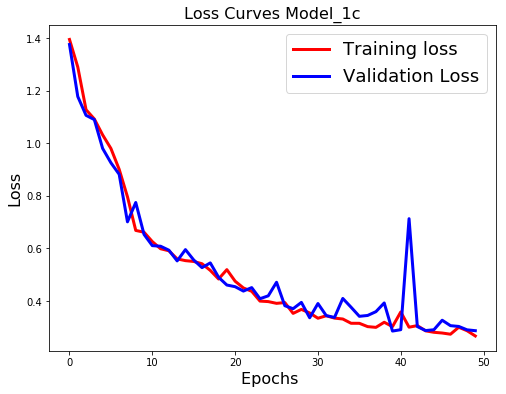

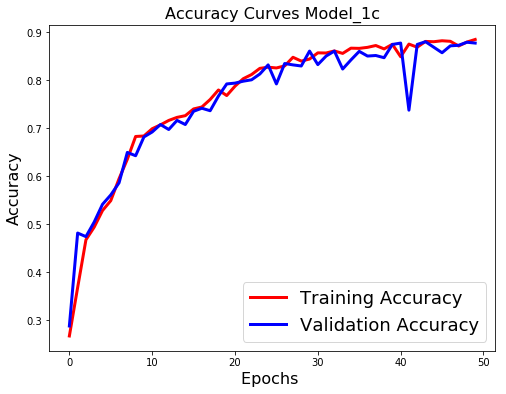

In [8]:
model_name = 'Model_1c'
model1c = Sequential()
model1c.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1c.add(MaxPooling2D(pool_size=(2, 2)))

model1c.add(Conv2D(32, (3, 3), activation='relu'))
model1c.add(MaxPooling2D(pool_size=(2, 2)))

model1c.add(Flatten())
model1c.add(Dense(128, activation='relu'))
model1c.add(Dense(4, activation='softmax'))
model1c.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

fit(model1c, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.80      0.92      0.85       617
  LYMPHOCYTE       0.97      0.98      0.97       599
    MONOCYTE       0.96      0.95      0.96       621
  NEUTROPHIL       0.89      0.75      0.81       604

   micro avg       0.90      0.90      0.90      2441
   macro avg       0.90      0.90      0.90      2441
weighted avg       0.90      0.90      0.90      2441

Confusion matrix, without normalization
[[569   8   2  38]
 [  7 586   5   1]
 [ 11   1 592  17]
 [127  11  15 451]]


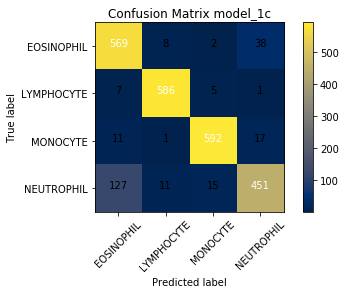

In [9]:
predict(model1c ,'model_1c',image_generator,2441,batch_size)

## Model 2 (depths of filter)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14976)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1917056   
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total para

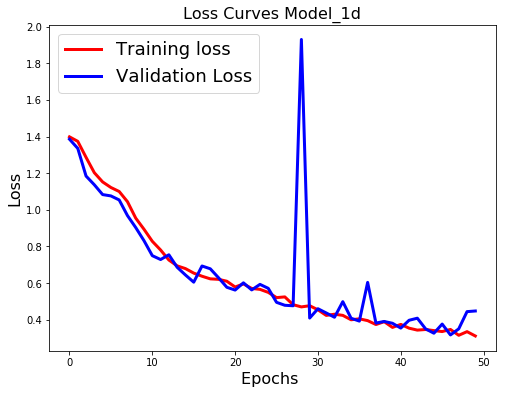

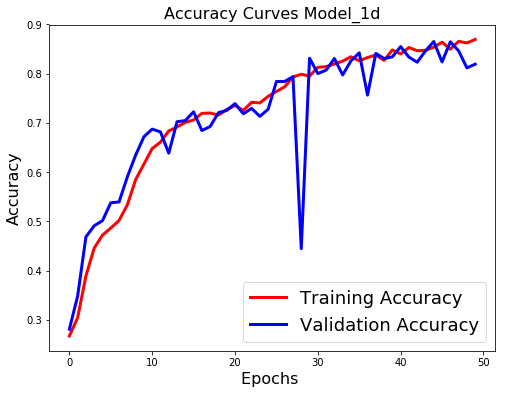

In [10]:
model_name = 'Model_1d'
model1d = Sequential()
model1d.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1d.add(MaxPooling2D(pool_size=(2, 2)))

model1d.add(Conv2D(64, (3, 3), activation='relu'))
model1d.add(MaxPooling2D(pool_size=(2, 2)))

model1d.add(Flatten())
model1d.add(Dense(128, activation='relu'))
model1d.add(Dense(4, activation='softmax'))
model1d.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model1d, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.75      0.65      0.70       617
  LYMPHOCYTE       0.88      0.80      0.84       599
    MONOCYTE       0.85      0.77      0.81       621
  NEUTROPHIL       0.61      0.80      0.69       604

   micro avg       0.76      0.76      0.76      2441
   macro avg       0.77      0.76      0.76      2441
weighted avg       0.77      0.76      0.76      2441

Confusion matrix, without normalization
[[404  59   4 150]
 [ 14 482  72  31]
 [ 11   3 478 129]
 [110   3   6 485]]


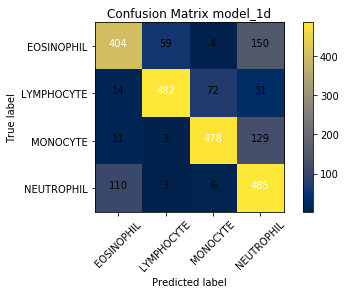

In [11]:
predict(model1d ,'model_1d',image_generator,2441,batch_size)

## Model 3 (selu activation)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14976)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1917056   
_________________________________________________________________
dens

Epoch 48/50
221/221 [==============================] - 69s 311ms/step - loss: 0.3554 - acc: 0.8557 - val_loss: 0.2920 - val_acc: 0.8797
Epoch 49/50
221/221 [==============================] - 69s 311ms/step - loss: 0.3429 - acc: 0.8615 - val_loss: 0.4820 - val_acc: 0.8123
Epoch 50/50
221/221 [==============================] - 68s 310ms/step - loss: 0.3585 - acc: 0.8557 - val_loss: 0.2789 - val_acc: 0.8745
0.8744962580188912


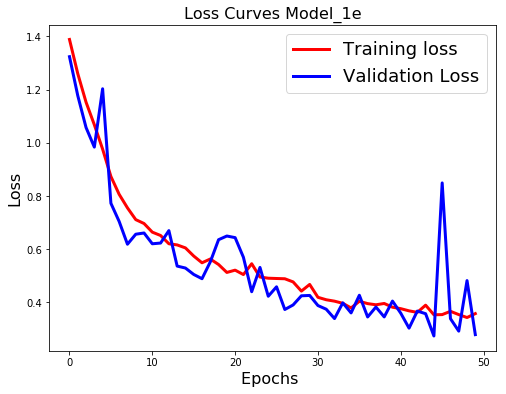

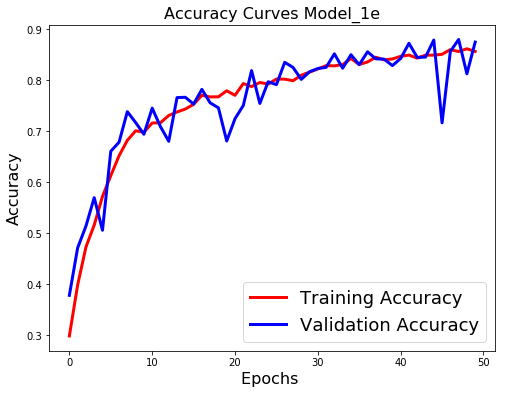

In [7]:
model_name = 'Model_1e'
model1e = Sequential()
model1e.add(Conv2D(32, kernel_size=(3, 3),
                     activation='selu',
                     input_shape=input_shape,strides=1))
model1e.add(MaxPooling2D(pool_size=(2, 2)))

model1e.add(Conv2D(64, (3, 3), activation='selu'))
model1e.add(MaxPooling2D(pool_size=(2, 2)))

model1e.add(Flatten())
model1e.add(Dense(128, activation='selu'))
model1e.add(Dense(4, activation='softmax'))
model1e.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

fit(model1e, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.76      0.81      0.78       617
  LYMPHOCYTE       0.92      0.89      0.91       599
    MONOCYTE       0.91      0.91      0.91       621
  NEUTROPHIL       0.79      0.75      0.77       604

   micro avg       0.84      0.84      0.84      2441
   macro avg       0.84      0.84      0.84      2441
weighted avg       0.84      0.84      0.84      2441

Confusion matrix, without normalization
[[498  39   4  76]
 [ 26 535  34   4]
 [  9   1 568  43]
 [124   4  21 455]]


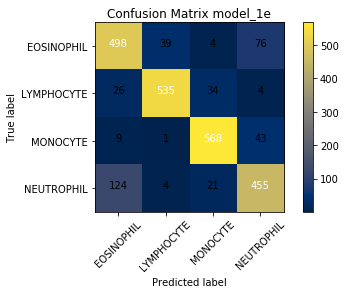

In [9]:
predict(model1e ,'model_1e',image_generator,2441,batch_size)

In [ ]:
model_name = 'Model_1f'
model1f = Sequential()
model1f.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1f.add(MaxPooling2D(pool_size=(2, 2)))

model1f.add(Conv2D(32, (3, 3), activation='relu'))
model1f.add(MaxPooling2D(pool_size=(2, 2)))

model1f.add(Flatten())
model1f.add(Dense(128, activation='relu'))
model1f.add(Dense(4, activation='softmax'))
model1f.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

fit(model1e, model_name, image_generator, batch_size, epochs, 7087, 1769)